**Some vehicles stopped in violation are exempt from fines due to business reasons. For vehicles that are exempt, are there repeat offenders? Where are exempt vehicles frequently in violation?**

*Recommendation - This problem is great for a mapping visualization! Choose a CUNY bus route that you are familiar with plot the long and latitude of where vehicles are in violation as well as the overall bus route.*

In [22]:
import requests
import random
import logging
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency
import os
import io

DATA_DIR_RAW = os.path.join("..", "..", "data", "raw")
DATA_DIR_PROCESSED = os.path.join("..", "..", "data", "processed")

# 🪵 Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [58]:
import matplotlib.font_manager as fm
import matplotlib as plt

available_fonts = sorted({f.name for f in fm.fontManager.ttflist})
plt.rcParams['font.family'] = 'Garamond'
plt.rcParams['font.size'] = 14

In [23]:
OUTPUT_ACE_NON_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_non_exempt_violations_2024.csv")
ACE_CBD_non_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_NON_CBD_2024)
ACE_CBD_non_exempt_violations_2024.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,route_id
0,466434011,0793aa5cb07e4fe2f0b708322397596b572bb8bb20ce57...,2024-12-31 10:54:43,2025-04-10T10:41:54.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.800044,-73.932396,401727,1 AV/E 116 ST,40.796303,-73.935089,POINT (-73.932396 40.800044),POINT (-73.935089 40.796303),M15+
1,466433995,f6e5765ff6839c918516f8590ff7d16f4c0cd727a83b70...,2024-12-31 08:31:27,2025-04-10T10:41:12.000,VIOLATION ISSUED,MOBILE BUS STOP,M101,40.776321,-73.955804,403433,3 AV/E 79 ST,40.774605,-73.956970,POINT (-73.955804 40.776321),POINT (-73.95697 40.774605),M101
2,466433863,b3608c6757c16d1433d98cca64bf29a7eeacd874c61281...,2024-12-31 15:59:11,2025-04-10T10:22:13.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.711928,-73.998177,403601,PEARL ST/BEEKMAN ST,40.708264,-74.003099,POINT (-73.998177 40.711928),POINT (-74.003099 40.708264),M15+
3,466433834,c97d07bd6e7c1756a5160064e8fcf1ecd83f2d41edbb3c...,2024-12-31 15:59:11,2025-04-10T10:20:34.000,VIOLATION ISSUED,MOBILE BUS STOP,M34+,40.742672,-73.977489,401824,E 34 ST /PARK AV,40.746929,-73.981102,POINT (-73.977489 40.742672),POINT (-73.981102 40.746929),M34+
4,466418716,575ad6f7c9a7153641b82d41f83f446ea7c64398a299cb...,2024-12-31 10:04:58,2025-04-09T12:42:33.000,VIOLATION ISSUED,MOBILE BUS STOP,M15+,40.771039,-73.953578,401707,1 AV/E 67 ST,40.764870,-73.958109,POINT (-73.953578 40.771039),POINT (-73.958109 40.76487),M15+


In [24]:
OUTPUT_ACE_CBD_2024 = os.path.join(DATA_DIR_RAW, "ACE_CBD_exempt_violations_2024.csv")
ACE_CBD_exempt_violations_2024 = pd.read_csv(OUTPUT_ACE_CBD_2024)
ACE_CBD_exempt_violations_2024.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference,route_id
0,452517324,3fbfaed0785d8e5a1c9ecc32b7e493e6ae07261ba9115e...,2024-12-31 10:54:43,2024-12-31T11:08:23.000,EXEMPT - COMMERCIAL UNDER 20,MOBILE DOUBLE PARKED,M101,40.832263,-73.942474,402526,AMSTERDAM AV/W 155 ST,40.831683,-73.942827,POINT (-73.942474 40.832263),POINT (-73.942827 40.831683),M101
1,452517306,ef6afb15ef2f996ef24568513e60cc25a1eb72d0b7c525...,2024-12-31 08:31:27,2024-12-31T08:35:31.000,EXEMPT - COMMERCIAL UNDER 20,MOBILE DOUBLE PARKED,M101,40.795071,-73.942076,402677,3 AV/E 37 ST,40.747988,-73.976370,POINT (-73.942076 40.795071),POINT (-73.97637 40.747988),M101
2,452517258,df1f37b3d595dc65291f25196d9e957b006e9472660bbb...,2024-12-31 15:59:11,2024-12-31T16:48:22.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842348,-73.935127,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.935127 40.842348),POINT (-73.935267 40.841978),M101
3,452517238,df1f37b3d595dc65291f25196d9e957b006e9472660bbb...,2024-12-31 15:59:11,2024-12-31T16:11:37.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842344,-73.935110,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.93511 40.842344),POINT (-73.935267 40.841978),M101
4,452461536,3f4f9c3891611af34c2290a19eb7c2b7cc62f8c66bbefd...,2024-12-31 10:04:58,2024-12-31T10:32:05.000,EXEMPT - EMERGENCY VEHICLE,MOBILE DOUBLE PARKED,M101,40.842417,-73.935064,402740,AMSTERDAM AV/W 171 ST,40.841978,-73.935267,POINT (-73.935064 40.842417),POINT (-73.935267 40.841978),M101


## Event - Closure Type: Full Sreet Closure

In [25]:
OUTPUT_CBD_EVENTS_2024 = os.path.join(DATA_DIR_RAW, "unique_events_geo.csv")
CBD_events_2024 = pd.read_csv(OUTPUT_CBD_EVENTS_2024)
CBD_events_2024.rename(columns={"lat": "latitude", "lon": "longitude"}, inplace=True)
CBD_events_2024.head()

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,event_street_side,street_closure_type,community_board,police_precinct,latitude,longitude
0,765291,Rock the Block 2024,09/08/2024 11:00:00 AM,09/08/2024 01:00:00 PM,Street Activity Permit Office,Block Party,Manhattan,DUANE STREET between GREENWICH STREET and HUDS...,Full,Full Street Closure,"1,","1,",40.717365,-74.009910
1,794292,Jewish New Years Street Festival,09/10/2024 04:30:00 PM,09/10/2024 06:30:00 PM,Street Activity Permit Office,Street Event,Manhattan,WEST 22 STREET between 6 AVENUE and 5 AVENUE,Full,Full Street Closure,"4, 5,","13,",40.741565,-73.991654
2,754646,Stone Street Pedestrian Mall,03/14/2024 11:00:00 AM,11/03/2024 10:00:00 PM,Street Activity Permit Office,Street Event,Manhattan,MILL LANE between SOUTH WILLIAM STREET and STO...,Full,Full Street Closure,"1,","1,",40.704671,-74.010203
3,774472,Dewitt Clinton Houses Family Day,09/07/2024 12:00:00 PM,09/07/2024 07:00:00 PM,Street Activity Permit Office,Block Party,Manhattan,EAST 110 STREET between LEXINGTON AVENUE and ...,Full,Full Street Closure,"11,","23,",40.795098,-73.945103
4,792155,Xavier High School Maroon and Blue Day,09/27/2024 10:00:00 AM,09/27/2024 01:00:00 PM,Street Activity Permit Office,Street Event,Manhattan,WEST 16 STREET between 5 AVENUE and 6 AVENUE,Full,Full Street Closure,"5,","13,",40.737999,-73.994185


C:\Users\aisha\AppData\Local\Temp\ipykernel_27784\3381773751.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")


SUMMARY:
  n_events: 70
  mean_exempt_event: 6.957142857142857
  median_exempt_event: 0.0
  mean_exempt_delta_vs_before: -0.2714285714285714
  mean_nonex_delta_vs_before: -0.2571428571428571
  mean_exempt_repeat_vehicles: 1.0


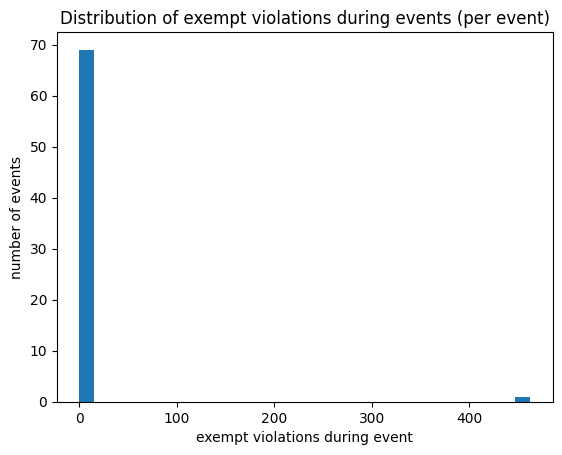

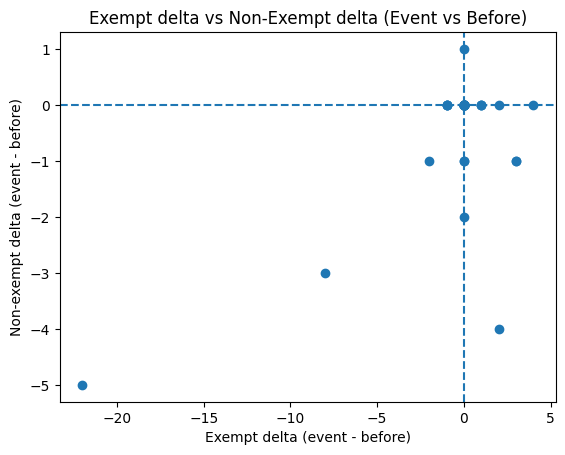

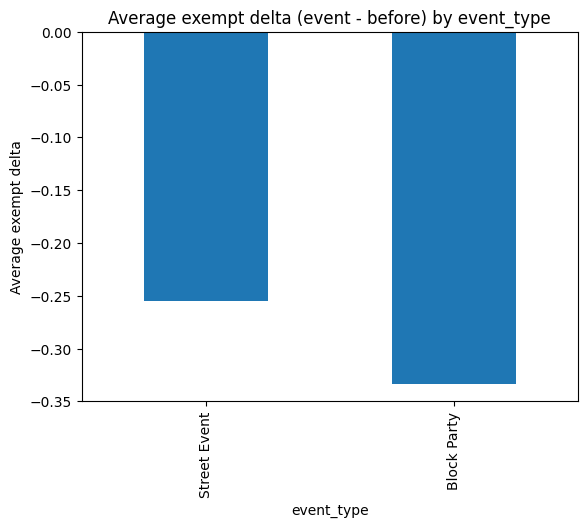

C:\Users\aisha\AppData\Local\Temp\ipykernel_27784\3381773751.py:266: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


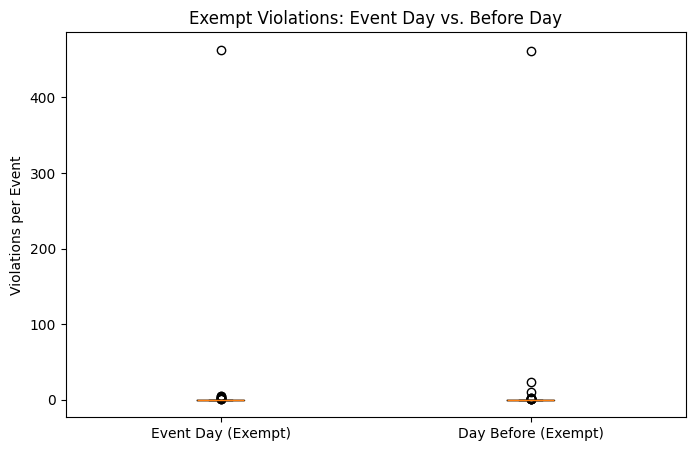

In [ ]:
# Dependencies:
# pip install pandas geopandas shapely matplotlib pyproj

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

# ---------- UTILITY / PREPROCESSING FUNCTIONS ----------

def to_datetime_cols(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def make_geodf_from_latlon(df, lat_col="violation_latitude", lon_col="violation_longitude", crs="EPSG:4326"):
    # Create geometry column from lat/lon
    df = df.copy()
    if lat_col in df.columns and lon_col in df.columns:
        df["geometry"] = df.apply(lambda r: Point(float(r[lon_col]), float(r[lat_col])), axis=1)
        gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
        return gdf
    else:
        raise KeyError(f"Missing lat/lon columns: {lat_col}, {lon_col}")

def event_point_gdf(events_df, lat_col="latitude", lon_col="longitude", crs="EPSG:4326"):
    df = events_df.copy()
    df["geometry"] = df.apply(lambda r: Point(float(r[lon_col]), float(r[lat_col])), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    return gdf

# ---------- MAIN PIPELINE FUNCTIONS ----------

def build_event_windows(events_df, before_days=1, after_days=1, use_same_weekday=False):
    """
    For each event row, produce a small DataFrame with event window and control windows.
    Returns a DataFrame with columns:
      event_id, event_start, event_end, ctrl_before_start, ctrl_before_end, ctrl_after_start, ctrl_after_end
    """
    rows = []
    for _, r in events_df.iterrows():
        event_id = r["event_id"]
        start = r["start_date_time"]
        end = r["end_date_time"]
        # If any are NaT, skip
        if pd.isna(start) or pd.isna(end):
            continue

        # Day before/after same hours
        before_start = start - timedelta(days=before_days)
        before_end = end - timedelta(days=before_days)
        after_start = start + timedelta(days=after_days)
        after_end = end + timedelta(days=after_days)

        # Optional: same weekday previous week control
        if use_same_weekday:
            before_start = start - timedelta(days=7)
            before_end = end - timedelta(days=7)

        rows.append({
            "event_id": event_id,
            "event_start": start,
            "event_end": end,
            "ctrl_before_start": before_start,
            "ctrl_before_end": before_end,
            "ctrl_after_start": after_start,
            "ctrl_after_end": after_end
        })

    ew = pd.DataFrame(rows)
    return ew

def filter_violations_spatial_temporal(violations_gdf, event_point, event_window_start, event_window_end, buffer_m=300):
    """
    Keep violations within buffer_m meters of event_point and whose first_occurrence or last_occurrence
    is within [event_window_start, event_window_end].
    - violations_gdf must be in EPSG:4326; will reproject to metric CRS for buffering.
    - event_point is a Shapely Point in same CRS (lon,lat).
    """
    # Reproject to a metric CRS for buffering (use UTM zone for NYC or global Mercator)
    # We'll use EPSG:3857 for simplicity (meters)
    v = violations_gdf.copy()
    v = v.to_crs(epsg=3857)
    # event_point geometry -> GeoSeries -> GeoDataFrame
    event_gdf = gpd.GeoDataFrame([{"geometry": event_point}], crs="EPSG:4326").to_crs(epsg=3857)
    buffer_geom = event_gdf.loc[0, "geometry"].buffer(buffer_m)

    # Spatial filter
    spatial_mask = v.geometry.within(buffer_geom)
    v_spatial = v.loc[spatial_mask].copy()

    # Temporal filter: check first_occurrence or last_occurrence columns
    time_mask = pd.Series(False, index=v_spatial.index)
    for tcol in ["first_occurrence", "last_occurrence"]:
        if tcol in v_spatial.columns:
            times = v_spatial[tcol]
            mask = (times >= event_window_start) & (times <= event_window_end)
            time_mask = time_mask | mask.fillna(False)

    v_final = v_spatial.loc[time_mask].copy()
    # Return back to original CRS (EPSG:4326)
    v_final = v_final.to_crs(epsg=4326)
    return v_final

def compute_event_counts_for_single_event(event_row, exempt_gdf, non_exempt_gdf, buffer_m=300):
    """
    Given one event (row containing event_id, latitude, longitude, event_start/event_end, etc),
    return a dict with counts: exempt_event_count, exempt_before_count, exempt_after_count,
    nonexempt_event_count, ...
    Also returns repeat-offender stats for exempt.
    """
    event_id = event_row["event_id"]
    event_start = event_row["event_start"]
    event_end = event_row["event_end"]
    before_start = event_row["ctrl_before_start"]
    before_end = event_row["ctrl_before_end"]
    after_start = event_row["ctrl_after_start"]
    after_end = event_row["ctrl_after_end"]

    # Build event point
    event_point = event_row["geometry"]

    # Spatial-temporal filters
    exempt_event = filter_violations_spatial_temporal(exempt_gdf, event_point, event_start, event_end, buffer_m)
    exempt_before = filter_violations_spatial_temporal(exempt_gdf, event_point, before_start, before_end, buffer_m)
    exempt_after = filter_violations_spatial_temporal(exempt_gdf, event_point, after_start, after_end, buffer_m)

    nonex_event = filter_violations_spatial_temporal(non_exempt_gdf, event_point, event_start, event_end, buffer_m)
    nonex_before = filter_violations_spatial_temporal(non_exempt_gdf, event_point, before_start, before_end, buffer_m)
    nonex_after = filter_violations_spatial_temporal(non_exempt_gdf, event_point, after_start, after_end, buffer_m)

    # Counts
    result = {
        "event_id": event_id,
        "exempt_event_count": len(exempt_event),
        "exempt_before_count": len(exempt_before),
        "exempt_after_count": len(exempt_after),
        "nonex_event_count": len(nonex_event),
        "nonex_before_count": len(nonex_before),
        "nonex_after_count": len(nonex_after),
    }

    # Repeat offender analysis (exempt)
    # Count violations per vehicle_id in each window
    def repeat_stats(gdf):
        if gdf.empty or "vehicle_id" not in gdf.columns:
            return {"repeat_vehicles": 0, "repeat_violations": 0, "unique_vehicles": 0}
        counts = gdf.groupby("vehicle_id").size()
        repeat_vehicles = (counts > 1).sum()
        repeat_violations = counts[counts > 1].sum()
        unique_vehicles = counts.size
        return {"repeat_vehicles": int(repeat_vehicles), "repeat_violations": int(repeat_violations), "unique_vehicles": int(unique_vehicles)}

    result.update({
        "exempt_event_repeat_vehicles": repeat_stats(exempt_event)["repeat_vehicles"],
        "exempt_event_repeat_violations": repeat_stats(exempt_event)["repeat_violations"],
        "exempt_event_unique_vehicles": repeat_stats(exempt_event)["unique_vehicles"],
        "exempt_before_repeat_vehicles": repeat_stats(exempt_before)["repeat_vehicles"],
        "exempt_after_repeat_vehicles": repeat_stats(exempt_after)["repeat_vehicles"],
    })

    # Optionally save ids of offending vehicles / top offenders
    result["exempt_event_top_vehicles"] = None
    if not exempt_event.empty:
        top = exempt_event.groupby("vehicle_id").size().sort_values(ascending=False).head(10)
        result["exempt_event_top_vehicles"] = top.to_dict()

    return result

# ---------- WRAPPER TO RUN FULL ANALYSIS OVER ALL EVENTS ----------

def run_full_event_analysis(exempt_df, nonex_df, events_df, buffer_m=300, use_same_weekday=False, event_gdf_crs="EPSG:4326"):
    # 1. Ensure date columns parsed
    exempt_df = to_datetime_cols(exempt_df, ["first_occurrence", "last_occurrence"])
    nonex_df = to_datetime_cols(nonex_df, ["first_occurrence", "last_occurrence"])
    events_df = to_datetime_cols(events_df, ["start_date_time", "end_date_time"])

    # 2. Convert violations to GeoDataFrames using their violation_latitude & violation_longitude
    exempt_gdf = make_geodf_from_latlon(exempt_df, lat_col="violation_latitude", lon_col="violation_longitude", crs=event_gdf_crs)
    nonex_gdf = make_geodf_from_latlon(nonex_df, lat_col="violation_latitude", lon_col="violation_longitude", crs=event_gdf_crs)

    # 3. Convert events to GeoDataFrame
    events_gdf = event_point_gdf(events_df, lat_col="latitude", lon_col="longitude", crs=event_gdf_crs)

    # 4. Build event windows
    event_windows = build_event_windows(events_gdf, before_days=1, after_days=1, use_same_weekday=use_same_weekday)
    # Join geometry & other event metadata into event_windows
    event_windows = event_windows.merge(events_gdf[["event_id", "geometry", "event_type", "street_closure_type", "event_name"]], on="event_id", how="left")

    # 5. Iterate events and compute counts
    results = []
    for _, ev in event_windows.iterrows():
        r = compute_event_counts_for_single_event(ev, exempt_gdf, nonex_gdf, buffer_m=buffer_m)
        # add metadata
        r["event_type"] = ev.get("event_type", None)
        r["street_closure_type"] = ev.get("street_closure_type", None)
        r["event_name"] = ev.get("event_name", None)
        results.append(r)

    results_df = pd.DataFrame(results)
    # Derived metrics
    results_df["exempt_delta_vs_before"] = results_df["exempt_event_count"] - results_df["exempt_before_count"]
    results_df["exempt_delta_vs_after"] = results_df["exempt_event_count"] - results_df["exempt_after_count"]
    results_df["nonex_delta_vs_before"] = results_df["nonex_event_count"] - results_df["nonex_before_count"]
    results_df["nonex_delta_vs_after"] = results_df["nonex_event_count"] - results_df["nonex_after_count"]

    # Percent changes (handle divide by zero)
    results_df["exempt_pct_change_vs_before"] = np.where(results_df["exempt_before_count"] > 0,
                                                        (results_df["exempt_event_count"] - results_df["exempt_before_count"]) / results_df["exempt_before_count"],
                                                        np.nan)
    results_df["nonex_pct_change_vs_before"] = np.where(results_df["nonex_before_count"] > 0,
                                                        (results_df["nonex_event_count"] - results_df["nonex_before_count"]) / results_df["nonex_before_count"],
                                                        np.nan)

    return results_df

# ---------- VISUALIZATION & SUMMARY FUNCTIONS ----------

def summarize_and_plot(results_df, top_n_eventtypes=10):
    # Basic aggregate summaries
    summary = {
        "n_events": len(results_df),
        "mean_exempt_event": results_df["exempt_event_count"].mean(),
        "median_exempt_event": results_df["exempt_event_count"].median(),
        "mean_exempt_delta_vs_before": results_df["exempt_delta_vs_before"].mean(),
        "mean_nonex_delta_vs_before": results_df["nonex_delta_vs_before"].mean(),
        "mean_exempt_repeat_vehicles": results_df["exempt_event_repeat_vehicles"].mean(),
    }
    print("SUMMARY:")
    for k, v in summary.items():
        print(f"  {k}: {v}")

    # Histogram: distribution of exempt_event_count
    plt.figure()
    plt.hist(results_df["exempt_event_count"].dropna(), bins=30)
    plt.title("Distribution of exempt violations during events (per event)")
    plt.xlabel("exempt violations during event")
    plt.ylabel("number of events")
    plt.show()

    # Scatter: exempt delta vs nonex delta
    plt.figure()
    plt.scatter(results_df["exempt_delta_vs_before"], results_df["nonex_delta_vs_before"])
    plt.axhline(0, linestyle="--")
    plt.axvline(0, linestyle="--")
    plt.title("Exempt delta vs Non-Exempt delta (Event vs Before)")
    plt.xlabel("Exempt delta (event - before)")
    plt.ylabel("Non-exempt delta (event - before)")
    plt.show()

    # Bar by event type (top event types)
    if "event_type" in results_df.columns:
        types = results_df.groupby("event_type")["exempt_delta_vs_before"].mean().sort_values(ascending=False).head(top_n_eventtypes)
        plt.figure()
        types.plot(kind="bar")
        plt.title("Average exempt delta (event - before) by event_type")
        plt.ylabel("Average exempt delta")
        plt.xlabel("event_type")
        plt.show()
    
    # 2. Event vs Control (Before Day) – Boxplot
    plt.figure(figsize=(8,5))
    plt.boxplot(
        [results_df["exempt_event_count"], results_df["exempt_before_count"]],
        labels=["Event Day (Exempt)", "Day Before (Exempt)"]
    )
    plt.title("Exempt Violations: Event Day vs. Before Day")
    plt.ylabel("Violations per Event")
    plt.show()

    return summary

# ---------- EXAMPLE: Run full pipeline (wrapped to not execute accidentally) ----------
if __name__ == "__main__":
    # If running interactively, remove the guard and call run_full_event_analysis with your real DataFrames:
    results = run_full_event_analysis(ACE_CBD_exempt_violations_2024, ACE_CBD_non_exempt_violations_2024, CBD_events_2024, buffer_m=300)
    summary = summarize_and_plot(results)
    pass

# ---------- NOTES & EXTENSIONS ----------
# 1) Buffer size (buffer_m): start with 200-400 meters; adjust based on spatial density.
# 2) Time windows: code currently uses exact event start/end hours. If you'd like to extend to +/- hours (e.g., 2 hours before/after),
#    modify build_event_windows to expand event_start/event_end by desired timedelta.
# 3) Day-of-week robustness: set use_same_weekday=True when calling run_full_event_analysis to compare event to same weekday prior week.
# 4) If event geocoding is noisy, you can match by bus_route_id if events include textual street segments; that requires mapping bus stops to street segments.
# 5) Save results: results_df.to_csv("event_violation_analysis_results.csv", index=False)

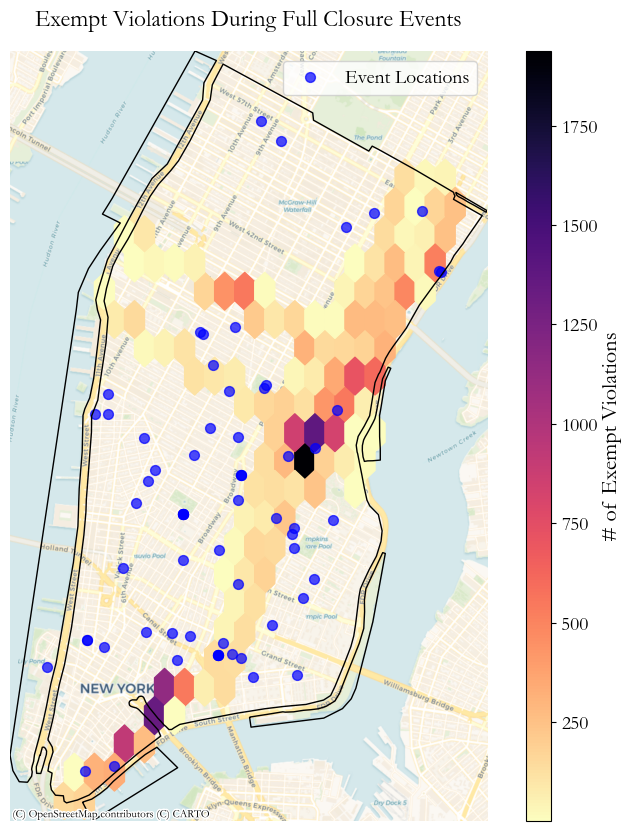

In [75]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

def plot_event_violation_heatmap(exempt_gdf, event_windows_df, cbd_shapefile, title="Exempt Violations During Full Closure Events"):
    """
    Plots a heatmap of exempt violations only during event windows, clipped to the CBD,
    and overlays event points.
    
    Parameters:
        exempt_gdf: GeoDataFrame of violations with 'first_occurrence' column
        event_windows_df: DataFrame with 'event_start', 'event_end' (datetime), 'geometry' columns
        cbd_shapefile: path to the CBD shapefile
        title: plot title
    """
    # Load CBD boundary
    cbd_boundary = gpd.read_file(cbd_shapefile)
    
    # Ensure CRS matches
    exempt_gdf = exempt_gdf.set_crs(epsg=4326, allow_override=True)
    cbd_boundary = cbd_boundary.to_crs(exempt_gdf.crs)
    
    # Ensure datetime column
    exempt_gdf["first_occurrence"] = pd.to_datetime(exempt_gdf["first_occurrence"], errors="coerce")
    
    # Filter violations inside any event window
    mask = pd.Series(False, index=exempt_gdf.index)
    for _, ev in event_windows_df.iterrows():
        if pd.notnull(ev.get("event_start")) and pd.notnull(ev.get("event_end")):
            mask |= (exempt_gdf["first_occurrence"] >= ev["event_start"]) & \
                    (exempt_gdf["first_occurrence"] <= ev["event_end"])
    
    event_violations = exempt_gdf.loc[mask].copy()
    
    # Clip to CBD
    cbd_event_violations = gpd.clip(event_violations, cbd_boundary)
    
    # Convert event points to GeoDataFrame and clip to CBD
    events_gdf = gpd.GeoDataFrame(event_windows_df, geometry="geometry", crs="EPSG:4326")
    events_gdf = gpd.clip(events_gdf, cbd_boundary)
    
    # Reproject for basemap
    cbd_event_violations = cbd_event_violations.to_crs(epsg=3857)
    events_gdf = events_gdf.to_crs(epsg=3857)
    cbd_boundary = cbd_boundary.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    if not cbd_event_violations.empty:
        x = cbd_event_violations.geometry.x
        y = cbd_event_violations.geometry.y
        hb = ax.hexbin(x, y, gridsize=20, cmap="magma_r", mincnt=1)
        cb = fig.colorbar(hb, ax=ax, aspect=30)
        cb.set_label("# of Exempt Violations", fontsize=16)
    else:
        print("No violations found during event windows inside the CBD.")
    
    # Overlay CBD boundary
    cbd_boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    
    # Overlay event points
    if not events_gdf.empty:
        events_gdf.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Event Locations")
        ax.legend()
    
    # Set axis limits to CBD bounds
    ax.set_xlim(cbd_boundary.total_bounds[0], cbd_boundary.total_bounds[2])
    ax.set_ylim(cbd_boundary.total_bounds[1], cbd_boundary.total_bounds[3])
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    
    ax.set_title(title)
    ax.axis("off")
    plt.show()

CBD_SHAPEFILE = os.path.join(DATA_DIR_RAW, "central_business_district.shp")

# Convert violations to GeoDataFrame
exempt_gdf = make_geodf_from_latlon(
    ACE_CBD_exempt_violations_2024,
    lat_col="violation_latitude",
    lon_col="violation_longitude"
)

# Build event windows
event_windows = build_event_windows(CBD_events_2024)
event_windows = event_windows.merge(
    event_point_gdf(CBD_events_2024)[["event_id", "geometry"]],
    on="event_id",
    how="left"
)

# Plot heatmap with event points
plot_event_violation_heatmap(exempt_gdf, event_windows, CBD_SHAPEFILE)


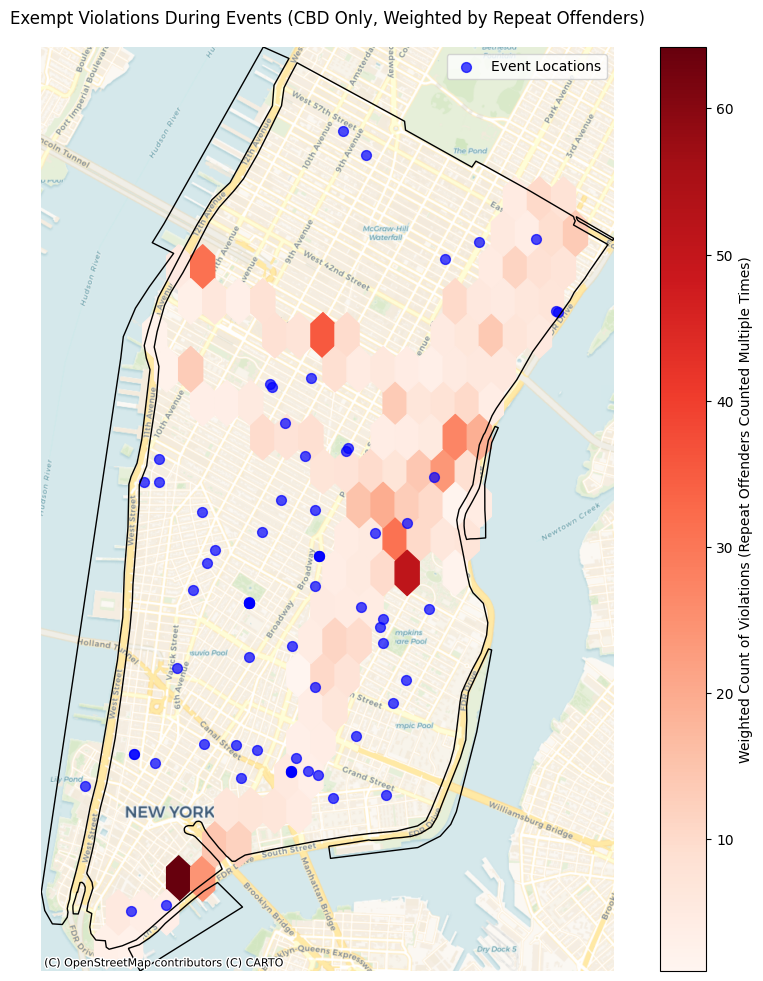

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd

def plot_event_violation_heatmap_with_events(exempt_gdf, event_windows_df, cbd_shapefile, title="Exempt Violations During Events (CBD Only, Weighted by Repeat Offenders)"):
    """
    Plots a heatmap of exempt violations during event windows, clipped to the CBD,
    weighted by repeat offenders, and overlays event locations.
    """
    # Load CBD boundary
    cbd_boundary = gpd.read_file(cbd_shapefile)
    
    # Ensure CRS matches
    exempt_gdf = exempt_gdf.set_crs(epsg=4326, allow_override=True)
    cbd_boundary = cbd_boundary.to_crs(exempt_gdf.crs)
    
    # Ensure datetime column
    exempt_gdf["first_occurrence"] = pd.to_datetime(exempt_gdf["first_occurrence"], errors="coerce")
    
    # Filter violations within event windows
    mask = pd.Series(False, index=exempt_gdf.index)
    for _, ev in event_windows_df.iterrows():
        if pd.notnull(ev.get("event_start")) and pd.notnull(ev.get("event_end")):
            mask |= (exempt_gdf["first_occurrence"] >= ev["event_start"]) & \
                    (exempt_gdf["first_occurrence"] <= ev["event_end"])
    
    event_violations = exempt_gdf.loc[mask].copy()
    
    if event_violations.empty:
        print("No violations found during event windows inside the CBD.")
        return
    
    # Count repeat violations per vehicle
    if "vehicle_id" in event_violations.columns:
        event_violations["weight"] = event_violations.groupby("vehicle_id")["vehicle_id"].transform("count")
    else:
        event_violations["weight"] = 1
    
    # Clip violations to CBD
    cbd_event_violations = gpd.clip(event_violations, cbd_boundary)
    
    # Convert event points to GeoDataFrame and clip to CBD
    events_gdf = gpd.GeoDataFrame(event_windows_df, geometry="geometry", crs="EPSG:4326")
    events_gdf = gpd.clip(events_gdf, cbd_boundary)
    
    # Reproject for basemap
    cbd_event_violations = cbd_event_violations.to_crs(epsg=3857)
    events_gdf = events_gdf.to_crs(epsg=3857)
    cbd_boundary = cbd_boundary.to_crs(epsg=3857)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    x = cbd_event_violations.geometry.x
    y = cbd_event_violations.geometry.y
    weights = cbd_event_violations["weight"]
    
    hb = ax.hexbin(x, y, C=weights, gridsize=20, cmap="Reds", mincnt=1)
    
    # Overlay CBD boundary
    cbd_boundary.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    
    # Overlay event points
    events_gdf.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Event Locations")
    
    # Set axis limits to CBD bounds
    ax.set_xlim(cbd_boundary.total_bounds[0], cbd_boundary.total_bounds[2])
    ax.set_ylim(cbd_boundary.total_bounds[1], cbd_boundary.total_bounds[3])
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    
    # Colorbar & title
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Weighted Count of Violations (Repeat Offenders Counted Multiple Times)")
    ax.set_title(title)
    ax.axis("off")
    ax.legend()
    plt.show()

CBD_SHAPEFILE = os.path.join(DATA_DIR_RAW, "central_business_district.shp")

# Convert violations to GeoDataFrame
exempt_gdf = make_geodf_from_latlon(
    ACE_CBD_exempt_violations_2024,
    lat_col="violation_latitude",
    lon_col="violation_longitude"
)

# Build event windows
event_windows = build_event_windows(CBD_events_2024)
event_windows = event_windows.merge(
    event_point_gdf(CBD_events_2024)[["event_id", "geometry"]],
    on="event_id",
    how="left"
)

# Plot heatmap weighted by repeat offenders with event points
plot_event_violation_heatmap_with_events(exempt_gdf, event_windows, CBD_SHAPEFILE)
